## imports

In [1]:
#dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split

from torchaudio import datasets
import torchaudio.transforms

from torch.utils.data import DataLoader

import pickle

# audio processing
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

# neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

#set device to GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## models

### VCTK Classifier

In [2]:
# class definition
class VCTKClassifier(nn.Module):
    def __init__(self):
        super(VCTKClassifier, self).__init__()
        
        #activation
        self.activation = nn.ReLU()
        
        #CONV LAYERS
        
        #interpret as one grayscale channel
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 8, kernel_size = (5, 5), stride = 2, padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 2, padding = 1)
        
        #POOLING
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        pool_h, pool_w = 2, 2
        self.adaptive_pooling = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        
        # define conv block
        self.conv_layers = nn.Sequential(
            self.conv1,
            self.activation,
            self.pool,
            self.conv2,
            self.activation,
            self.pool,
            self.conv3,
            self.activation,
            self.pool,
            self.conv4,
            self.activation,
            self.pool
        )
        
        #FULLY CONNECTED LAYERS
        
        self.fc1 = nn.Linear(pool_h * pool_w * self.conv4.out_channels, 256)
        self.fc2 = nn.Linear(256, 108)
        
    def forward(self, x):
        # through conv layers
        out = self.conv_layers(x)
        
        # adaptive pooling to standardise feature map size
        out = self.adaptive_pooling(out)
        
        # flatten feature maps
        out = out.view(out.size(0), -1)
        
        # through connected layers
        out = self.activation(self.fc1(out))
        out = self.fc2(out)
        return out

In [141]:
# initialise model instance, load pretrained weights
VCTKClassifier_model = VCTKClassifier().to(device)
VCTKClassifier_model.load_state_dict(torch.load("comp_model_params_ep_9.pth"))
VCTKClassifier_model.eval()

VCTKClassifier(
  (activation): ReLU()
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pooling): AdaptiveAvgPool2d(output_size=(2, 2))
  (conv_layers): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, 

### testing model accuracy

In [4]:
# define test set

# dataset definition for testing
class STFTC_Dataset(Dataset):
    def __init__(self, root: str):
        self.root_path = root + "/"
        
    def __len__(self):
        # hard code as length will not change and to prevent needing to access original dataset
        return 43873
    
    def __getitem__(self, idx):
        with open(self.root_path + "stftc" + str(idx), "rb") as file:
            pickled_list = pickle.load(file)
        
        target_input, target_label = pickled_list
        return torch.from_numpy(target_input).float(), target_label
    
# initialise dataset
stftc_data = STFTC_Dataset("STFTcomp")

# split to gain training set
split_ratio = 0.8
train_size = int(split_ratio * stftc_data.__len__())
test_size = stftc_data.__len__() - train_size

ipstft_test = random_split(stftc_data, [train_size, test_size])[1]

In [5]:
# dictionary for y labels

label_dict = {
    ('p225',): 0, ('p226',): 1, ('p227',): 2, ('p228',): 3, ('p229',): 4, ('p230',): 5, ('p231',): 6, ('p232',): 7, 
    ('p233',): 8, ('p234',): 9, ('p236',): 10, ('p237',): 11, ('p238',): 12, ('p239',): 13, ('p240',): 14, ('p241',): 15, 
    ('p243',): 16, ('p244',): 17, ('p245',): 18, ('p246',): 19, ('p247',): 20, ('p248',): 21, ('p249',): 22, ('p250',): 23, 
    ('p251',): 24, ('p252',): 25, ('p253',): 26, ('p254',): 27, ('p255',): 28, ('p256',): 29, ('p257',): 30, ('p258',): 31, 
    ('p259',): 32, ('p260',): 33, ('p261',): 34, ('p262',): 35, ('p263',): 36, ('p264',): 37, ('p265',): 38, ('p266',): 39, 
    ('p267',): 40, ('p268',): 41, ('p269',): 42, ('p270',): 43, ('p271',): 44, ('p272',): 45, ('p273',): 46, ('p274',): 47, 
    ('p275',): 48, ('p276',): 49, ('p277',): 50, ('p278',): 51, ('p279',): 52, ('p281',): 53, ('p282',): 54, ('p283',): 55, 
    ('p284',): 56, ('p285',): 57, ('p286',): 58, ('p287',): 59, ('p288',): 60, ('p292',): 61, ('p293',): 62, ('p294',): 63, 
    ('p295',): 64, ('p297',): 65, ('p298',): 66, ('p299',): 67, ('p300',): 68, ('p301',): 69, ('p302',): 70, ('p303',): 71, 
    ('p304',): 72, ('p305',): 73, ('p306',): 74, ('p307',): 75, ('p308',): 76, ('p310',): 77, ('p311',): 78, ('p312',): 79, 
    ('p313',): 80, ('p314',): 81, ('p316',): 82, ('p317',): 83, ('p318',): 84, ('p323',): 85, ('p326',): 86, ('p329',): 87, 
    ('p330',): 88, ('p333',): 89, ('p334',): 90, ('p335',): 91, ('p336',): 92, ('p339',): 93, ('p340',): 94, ('p341',): 95, 
    ('p343',): 96, ('p345',): 97, ('p347',): 98, ('p351',): 99, ('p360',): 100, ('p361',): 101, ('p362',): 102, ('p363',): 103, 
    ('p364',): 104, ('p374',): 105, ('p376',): 106, ('s5',): 107
}

In [6]:
# dataloader for test set
def collate_pad(batch):
    # sort by length in descending order
    batch.sort(key = lambda x: x[0].shape[2], reverse = True)
    max_length = batch[0][0].shape[2]
    
    # pad all inputs to same length
    padded_X = []
    for item in batch:
        tensor, label = item
        pad_size = max_length - tensor.shape[2]
        padded = F.pad(tensor, (0, pad_size))
        padded_X.append(padded)
    
    # return padded X in a stack
    X = torch.stack(padded_X)
    
    # convert labels to one-hot stack
    dict_labels = torch.tensor([label_dict[(item[1],)] for item in batch])
    y = F.one_hot(dict_labels, len(label_dict)).float()
    
    return X, y

# dataloader initialisation and loss func
stfc_testloader = DataLoader(stftc_data, batch_size = 32, shuffle = False, collate_fn = collate_pad)

In [7]:
# run test

loss_fn = nn.CrossEntropyLoss()

# define testing func
def test(dataloader, model, loss_fn):
    max_length = len(dataloader.dataset)
    batch_length = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            hx = model(X)
            test_loss += loss_fn(hx, y).item()
            
            correct += (hx.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            
        test_loss /= batch_length
        correct /= max_length
        print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
#test(stfc_testloader, VCTKClassifier_model, loss_fn)

## style transfer loss functions

### style loss

In [8]:
# gram matrix

def gram_matrix(input_featuremaps):
    if input_featuremaps.dim() == 4:
        batch_size, n_featuremaps, f_m, f_n = input_featuremaps.size()
    
        # stack flattened feature vectors into a matrix
        feature_vecs = input_featuremaps.view(batch_size * n_featuremaps, f_m * f_n)
        
    elif input_featuremaps.dim() == 2:
        feature_vecs = input_featuremaps
        batch_size = input_featuremaps.size()[0] / 2
        n_featuremaps = 2
        f_m = input_featuremaps.size()[1]
        f_n = 1
        #print(input_featuremaps.size())
        #print(batch_size * n_featuremaps * f_m * f_n)

    # multiply feature vec matrix by its transpose for gram matrix
    G_mat = torch.mm(feature_vecs, feature_vecs.t())
    #print(G_mat.size())
    
    # normalise matrix by total number of elements in feature maps
    G_mat = torch.div(G_mat, batch_size * n_featuremaps * f_m * f_n)
    
    return G_mat

In [9]:
# style loss module

class StyleLoss(nn.Module):
    def __init__(self, style_featuremaps):
        super(StyleLoss, self).__init__()
        
        # detach() to remove from backprop tree (remove from dynamic gradient computation)
        self.style_G_mat = gram_matrix(style_featuremaps).detach()
        
    def forward(self, x):
        x_G_mat = gram_matrix(x)
        self.loss = F.mse_loss(x_G_mat, self.style_G_mat)
        return x

### content loss

In [10]:
# content loss module

class ContentLoss(nn.Module):
    def __init__(self, content):
        super(ContentLoss, self).__init__()
        
        # detach() to remove from backprop tree (remove from dynamic gradient computation)
        self.content = content.detach()
        
    def forward(self, x):
        self.loss = F.mse_loss(x, self.content)
        return x

## running style transfer

### audio processing functions

In [11]:
# load waveform array
def load_audio(filepath):
    audio, sr = librosa.load(filepath, sr = 48000)
    audio = np.squeeze(audio)
    return audio

# standardise an STFT with given mean/std
def normalise_stft(stft, mean, std):
    std = np.where(std == 0, 1, std)
    stft = (stft - mean[:, :, np.newaxis]) / std[:, :, np.newaxis]
    return stft

# return from standardised STFT to un-standardised data
def un_normalise_stft(stft, mean, std):
    std = np.where(std == 0, 1, std)
    stft = (stft * std[:, :, np.newaxis]) + mean[:, :, np.newaxis]
    return stft

# return from split representation to 2D complex-valued matrix
def get_complex_stft(stft):
    real = stft[0]
    comp = stft[1]
    return stft[0] + 1j * stft[1]

# convert waveform to STFT; split complex values into stack of len 2
def to_stft(audio):
    #512 is the recommended length for windowed signal (speech)
    audio_stft = librosa.stft(audio, n_fft = 512)
    
    # processing
    real = np.real(audio_stft)
    imag = np.imag(audio_stft)
    audio_stft_sep = np.stack([real, imag])
    
    return audio_stft_sep

# function taken from source: https://librosa.org/doc/main/generated/librosa.stft.html
def print_stft(stft, title):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(stft,
                                                           ref=np.max),
                                   y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title + " spectrogram")
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    fig

### get style and content losses from model(s)

In [102]:
def get_style_content_loss_model(cnn, style_audio, content_audio):
    content_layers = ["conv3", "conv4"]
    # idea: use it on adaptive pooled?
    style_layers = ["conv1", "conv2"]
    
    # model for style and content loss
    sc_model = nn.Sequential().to(device)
    
    ind = 0
    
    # pad the shorter audio with 0s
    style_len = style_audio.shape[0]
    content_len = content_audio.shape[0]
    
    if style_len > content_len:
        content_audio = np.pad(content_audio, (0, style_len - content_len), "constant")
    else:
        style_audio = np.pad(style_audio, (0, content_len - style_len), "constant")
    
    # turn audio into stft and normalise by VCTK mean, std
    mean = np.load("mean_comp.npy")
    std = np.load("std_comp.npy")
    style_stft = torch.from_numpy(normalise_stft(to_stft(style_audio), mean, std)).float()
    content_stft = torch.from_numpy(normalise_stft(to_stft(content_audio), mean, std)).float()
    
    style_stft = style_stft[None, :, :, :].to(device)
    content_stft = content_stft[None, :, :, :].to(device)
    
    content_losses = []
    style_losses = []
    
    # traverse to find conv layers
    for layer in cnn.children():
        # find the sequential block with the convolutional layer stack
        if isinstance(layer, nn.Sequential):
            for seq_layer in layer:
                # label the layers, add to sc model
                if isinstance(seq_layer, nn.Conv2d):
                    ind = ind + 1
                    layer_name = "conv" + str(ind)
                elif isinstance(seq_layer, nn.ReLU):
                    layer_name = "relu" + str(ind)
                elif isinstance(seq_layer, nn.MaxPool2d):
                    layer_name = "pool" + str(ind)
                    
                sc_model.add_module(layer_name, seq_layer)
                
                if layer_name in content_layers:
                    content_target = sc_model(content_stft).detach()
                    content_loss = ContentLoss(content_target)
                    sc_model.add_module("con_loss" + str(ind), content_loss)
                    content_losses.append(content_loss)
                    
                if layer_name in style_layers:
                    style_target = sc_model(style_stft).detach()
                    style_loss = StyleLoss(style_target)
                    sc_model.add_module("sty_loss" + str(ind), style_loss)
                    style_losses.append(style_loss)
                    
                
    return sc_model, style_losses, content_losses

class FlattenModule(nn.Module):
    def __init__(self):
        super(FlattenModule, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

def alternate_style_model(cnn, style_audio, content_audio):
    content_layers = ["conv3", "conv4"]
    # idea: use it on adaptive pooled?
    style_layers = ["conv1", "conv2", "conv3", "conv4", "fc1"]
    
    # model for style and content loss
    sc_model = nn.Sequential().to(device)
    
    ind = 0
    
    # pad the shorter audio with 0s
    style_len = style_audio.shape[0]
    content_len = content_audio.shape[0]
    
    if style_len > content_len:
        content_audio = np.pad(content_audio, (0, style_len - content_len), "constant")
    else:
        style_audio = np.pad(style_audio, (0, content_len - style_len), "constant")
    
    # turn audio into stft and normalise by VCTK mean, std
    mean = np.load("mean_comp.npy")
    std = np.load("std_comp.npy")
    style_stft = torch.from_numpy(normalise_stft(to_stft(style_audio), mean, std)).float()
    content_stft = torch.from_numpy(normalise_stft(to_stft(content_audio), mean, std)).float()
    
    style_stft = style_stft[None, :, :, :].to(device)
    content_stft = content_stft[None, :, :, :].to(device)
    
    content_losses = []
    style_losses = []
    
    outer_ind = 0
    
    # traverse to find layers
    for layer in cnn.children():
        # find the sequential block with the convolutional layer stack
        if isinstance(layer, nn.Sequential):
            for seq_layer in layer:
                # label the layers, add to sc model
                if isinstance(seq_layer, nn.Conv2d):
                    ind = ind + 1
                    layer_name = "conv" + str(ind)
                elif isinstance(seq_layer, nn.ReLU):
                    layer_name = "relu" + str(ind)
                elif isinstance(seq_layer, nn.MaxPool2d):
                    layer_name = "pool" + str(ind)
                    
                sc_model.add_module(layer_name, seq_layer)
                
                if layer_name in content_layers:
                    content_target = sc_model(content_stft).detach()
                    content_loss = ContentLoss(content_target)
                    sc_model.add_module("con_loss" + str(ind), content_loss)
                    content_losses.append(content_loss)
                    
                if layer_name in style_layers:
                    style_target = sc_model(style_stft).detach()
                    style_loss = StyleLoss(style_target)
                    sc_model.add_module("sty_loss" + str(ind), style_loss)
                    style_losses.append(style_loss)
                    
    if "fc1" in style_layers:
        sc_model.add_module("ad_pool", cnn.adaptive_pooling)
        #sc_model.add_module("flatten", FlattenModule())
        #sc_model.add_module("fc1", cnn.fc1)
        style_target = sc_model(style_stft).detach()
        style_loss = StyleLoss(style_target)
        sc_model.add_module("sty_loss_fc", style_loss)
        style_losses.append(style_loss)
        #sc_model.add_module("post_fc_relu", nn.ReLU())
    elif "fc1" in content_layers:
        sc_model.add_module("ad_pool", cnn.adaptive_pooling)
        #sc_model.add_module("flatten", FlattenModule())
        #sc_model.add_module("fc1", cnn.fc1)
        content_target = sc_model(content_stft).detach()
        content_loss = ContentLoss(content_target)
        sc_model.add_module("con_loss_fc", content_loss)
        content_losses.append(content_loss)
        #sc_model.add_module("post_fc_relu", nn.ReLU())
                    
                
    return sc_model, style_losses, content_losses
                

In [79]:
# sanity check
for item in get_style_content_loss_model(VCTKClassifier_model, style_audio, content_audio):
    print(item)
    
for item in alternate_style_model(VCTKClassifier_model, style_audio, content_audio):
    print(item)  

Sequential(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (sty_loss1): StyleLoss()
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (sty_loss2): StyleLoss()
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (con_loss3): ContentLoss()
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (con_loss4): ContentLoss()
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
[StyleLoss(), StyleLoss()]
[ContentLoss(), ContentLoss()]
Sequential(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (con_l

### generating new audio/gradient descent

In [138]:
def audio_style_transfer(cnn, style_audio, content_audio, synth_audio, steps,
                        style_weight, content_weight):
    # normalisation parameters
    mean = np.load("mean_comp.npy")
    std = np.load("std_comp.npy")
    
    # obtain model with loss/content modules
    sc_model, style_losses, content_losses = get_style_content_loss_model(VCTKClassifier_model, style_audio, content_audio)
    #sc_model, style_losses, content_losses = alternate_style_model(VCTKClassifier_model, style_audio, content_audio)
    
    # synth audio of len content audio; if style audio longer then pad synth to same length
    synth_audio_len = synth_audio.shape[0]
    style_audio_len = style_audio.shape[0]
    content_audio_len = content_audio.shape[0]
    
    if style_audio_len > synth_audio_len:
        synth_audio = np.pad(synth_audio, (0, style_audio_len - synth_audio_len), "constant")
    elif content_audio_len > synth_audio_len:
        synth_audio = np.pad(synth_audio, (0, content_audio_len - synth_audio_len), "constant")
        
    # use requires grad to specify the input is to be adjusted, not the model
    # tensor must be contiguous for optimiser to work
    synth_stft = torch.from_numpy(normalise_stft(to_stft(synth_audio), mean, std)).float().contiguous()
    synth_stft = synth_stft[None, :, :, :].to(device)
    synth_stft.requires_grad_(True)
    
    sc_model.eval()
    sc_model.requires_grad_(False)
    
    # optimiser for gradient descent on input
    optimiser = torch.optim.LBFGS([synth_stft])
    #optimiser = torch.optim.Adam([synth_stft], lr = 0.3)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma = 0.8)
    
    global step_no
    step_no = 0
    while step_no <= steps:
        def closure():
            #with torch.no_grad():
            #    synth_stft.clamp_(0, 1)
                
            optimiser.zero_grad()
            sc_model(synth_stft)
            
            # get style/content losses
            style_loss_total = 0
            content_loss_total = 0
            
            for module in style_losses:
                style_loss_total = style_loss_total + module.loss
            for module in content_losses:
                content_loss_total = content_loss_total + module.loss
            
            # apply weighting
            style_loss_total = style_loss_total * style_weight
            content_loss_total = content_loss_total * content_weight
            
            total_loss = style_loss_total + content_loss_total
            total_loss.backward()
            
            global step_no
            step_no = step_no + 1
            #if step_no % (steps / 100) == 0:
                #scheduler.step()
            if step_no % (steps / 10) == 0:
                step_mes = "Step " + str(step_no) + "/" + str(steps)
                print("\n" + step_mes + ":")
                print("Style Loss: " + str(style_loss_total.item()))
                print("Content Loss: " + str(content_loss_total.item()))
                #scheduler.step()
                
                # to visualise convergence, print spectrogram
                stft_copy = synth_stft.detach().clone().squeeze()
                stft_copy = get_complex_stft(un_normalise_stft(stft_copy.cpu().numpy(), mean, std))
                print_stft(stft_copy, step_mes)
                
            return style_loss_total + content_loss_total
        
        optimiser.step(closure)
    
    #with torch.no_grad():
    #    synth_stft.clamp_(-1, 1)
    
    return synth_stft

## run algorithm on data


Step 500/5000:
Style Loss: 0.07509376108646393
Content Loss: 139.40345764160156

Step 1000/5000:
Style Loss: 0.17879274487495422
Content Loss: 71.72245788574219

Step 1500/5000:
Style Loss: 0.2705690264701843
Content Loss: 2.557694435119629

Step 2000/5000:
Style Loss: 0.10112535208463669
Content Loss: 0.516887366771698

Step 2500/5000:
Style Loss: 0.07397531718015671
Content Loss: 0.3889228105545044

Step 3000/5000:
Style Loss: 0.0621613934636116
Content Loss: 0.3514558970928192

Step 3500/5000:
Style Loss: 0.0558285266160965
Content Loss: 0.3296665847301483

Step 4000/5000:
Style Loss: 0.052252862602472305
Content Loss: 0.31635668873786926

Step 4500/5000:
Style Loss: 0.04989824816584587
Content Loss: 0.30454984307289124

Step 5000/5000:
Style Loss: 0.04803719371557236
Content Loss: 0.2962748110294342


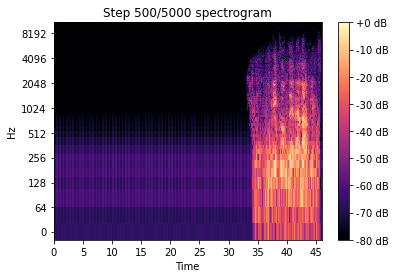

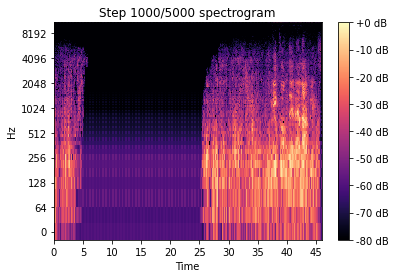

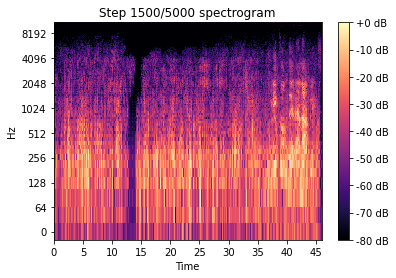

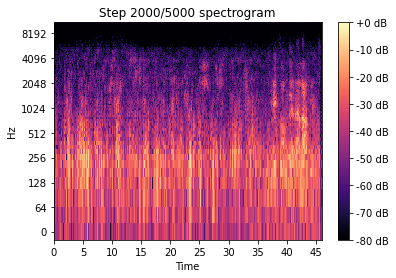

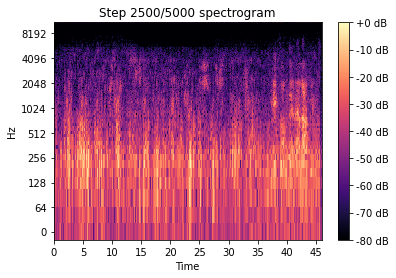

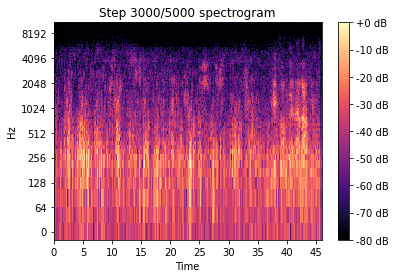

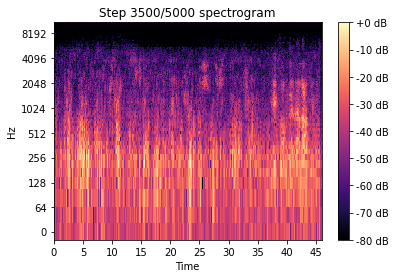

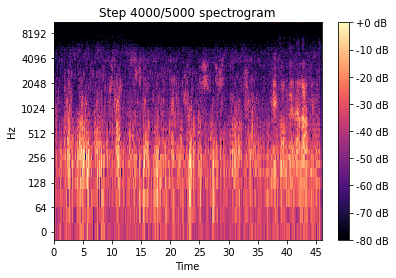

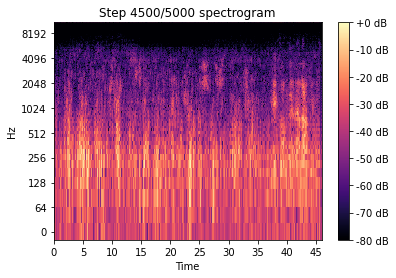

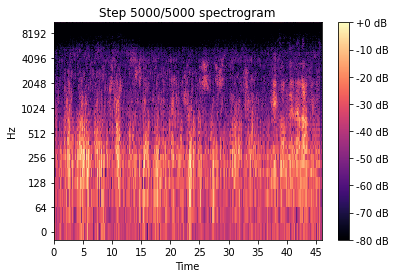

In [164]:
# get style audio
# get content audio
#style_audio = load_audio("VCTK\VCTK-Corpus-0.92\wav48_silence_trimmed\p225\p225_006_mic2.flac")
#content_audio = load_audio("VCTK\VCTK-Corpus-0.92\wav48_silence_trimmed\p304\p304_009_mic2.flac")
style_audio = load_audio("audioinpex\\human_female_greetings_08.wav")
content_audio = load_audio("audioinpex\\girl.wav")

#frameshift idea
style_audio = np.pad(style_audio, (content_audio.shape[0], 0), "constant")

style_weight = 1e3
content_weight = 1
steps = 5000

# clone content for synth audio
#synth_audio = np.random.randn(content_audio.shape[0])
#synth_audio = np.copy(content_audio)
synth_audio = np.copy(style_audio)
synth_stft = audio_style_transfer(VCTKClassifier_model, style_audio, content_audio, synth_audio, steps,
                                 style_weight, content_weight)

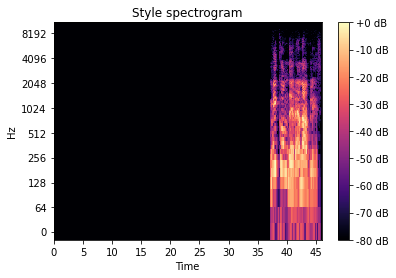

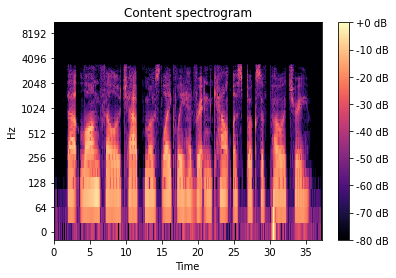

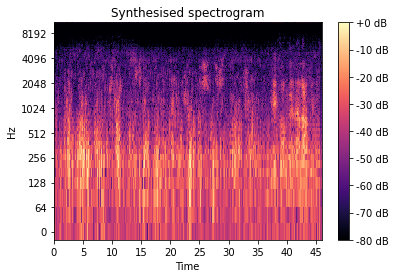

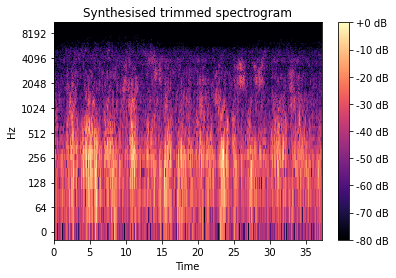

In [165]:
# un-standardise STFT
mean = np.load("mean_comp.npy")
std = np.load("std_comp.npy")

synth_stft = synth_stft.detach().squeeze().cpu().numpy()
synth_stft_unnorm_complex = get_complex_stft(un_normalise_stft(synth_stft, mean, std))

# display reference and generated audio
print_stft(librosa.stft(style_audio, n_fft = 512), "Style")
print_stft(librosa.stft(content_audio, n_fft = 512), "Content")
print_stft(synth_stft_unnorm_complex, "Synthesised")

# generate output waveform and trim to original length
output_audio = librosa.istft(synth_stft_unnorm_complex, n_fft = 512)
if (output_audio.shape[0] > content_audio.shape[0]):
    output_audio = output_audio[:content_audio.shape[0]]

# display stft of trimmed output waveform
print_stft(librosa.stft(output_audio, n_fft = 512), "Synthesised trimmed")
#write output to file
sf.write("output.wav", output_audio, 48000, subtype='PCM_24')

In [159]:
# sanity test for audio process reversibility
test_norm = normalise_stft(to_stft(style_audio), mean, std)
test_unnorm = get_complex_stft(un_normalise_stft(test_norm, mean, std))
test_output = librosa.istft(test_unnorm, n_fft = 512)
sf.write("testoutput.wav", test_output, 48000, subtype='PCM_24')